In [ ]:
# import library
import numpy as np
import pandas as pd
import string
from string import digits
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/C4_200M.tsv-00000-of-00010.zip

In [ ]:
import pandas as pd

# Specify the filename of the unzipped TSV file
file_path = "C4_200M.tsv-00000-of-00010"

# Read the TSV file into a DataFrame
data = pd.read_csv(file_path, sep='\t', nrows=100)
data.columns=["input","target"]


print(data.head())


                                               input  \
0  The effect of widespread dud targets two face ...   
1  tax on sales of stores for non residents are s...   
2  Much many brands and sellers still in the market.   
3  this is is the latest Maintenance release of S...   
4  Fairy Or Not, I'm the Godmother: no just look,...   

                                              target  
0  1. The effect of "widespread dud" targets two ...  
1  Capital Gains tax on the sale of properties fo...  
2       Many brands and sellers still in the market.  
3  This is is the latest maintenance release of S...  
4  Fairy Or Not, I'm the Godmother: Not just a lo...  


In [ ]:
# smaple of data
data.head()

,input,target
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
1,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
2,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
3,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...
4,"Fairy Or Not, I'm the Godmother: no just look,...","Fairy Or Not, I'm the Godmother: Not just a lo..."


In [ ]:
# shape
data.shape

(100, 2)

In [ ]:
# clean data
def clean(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later.
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = str.maketrans('', '',string.punctuation)
  lines.input=lines.input.apply(lambda x: x.translate(exclude))
  lines.target=lines.target.apply(lambda x: x.translate(exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))


In [ ]:
#adjust data
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  clean(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)
data_prep(data)

In [ ]:
# smaple of data
data.head(2)

,input,target
0,the effect of widespread dud targets two face ...,START_ the effect of widespread dud targets t...
1,tax on sales of stores for non residents are s...,START_ capital gains tax on the sale of proper...


In [ ]:
#get tokens
def tok_split_word2word(data):
  return data.split()
tok_split_fn = tok_split_word2word

In [ ]:
def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
  input_tokens=set()
  for line in lines.input:
      for tok in input_tok_split_fn(line):
          if tok not in input_tokens:
              input_tokens.add(tok)

  target_tokens=set()
  for line in lines.target:
      for tok in target_tok_split_fn(line):
          if tok not in target_tokens:
              target_tokens.add(tok)
  input_tokens = sorted(list(input_tokens))
  target_tokens = sorted(list(target_tokens))

  num_encoder_tokens = len(input_tokens)
  num_decoder_tokens = len(target_tokens)
  max_encoder_seq_length = np.max([len(input_tok_split_fn(l)) for l in lines.input])
  max_decoder_seq_length = np.max([len(target_tok_split_fn(l)) for l in lines.target])

  return input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length

In [ ]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(data, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(data))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 100
Number of unique input tokens: 1067
Number of unique output tokens: 1057
Max sequence length for inputs: 121
Max sequence length for outputs: 118


In [ ]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [ ]:
def vocab(input_tokens, target_tokens):

  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset

  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [ ]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

In [ ]:
max_encoder_seq_length = 500
max_decoder_seq_length = 250

In [ ]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')

  return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok]
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.

  return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(data, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

In [ ]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)

    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM


    encoder_states = [state_h, state_c]
    print(encoder_states)

    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.00001), loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary())

    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)


    decoder_states = [state_h, state_c]

    attention = att_dot([decoder_outputs, decoder_encoder_inputs])

    attention = att_activation(attention)

    context = context_dot([attention, decoder_encoder_inputs])



    decoder_combined_context = att_context_concat([context, decoder_outputs])

    decoder_outputs = decoder_dense(decoder_combined_context)

    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)

    return model, encoder_model, decoder_model

In [ ]:
emb_sz = 100

[<KerasTensor: shape=(None, 200) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 200) dtype=float32 (created by layer 'concatenate_1')>]


KerasTensor(type_spec=TensorSpec(shape=(None, None, 200), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 200), dtype=tf.float32, name=None), name='bidirectional/concat:0', description="created by layer 'bidirectional'")
attention KerasTensor(type_spec=TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), name='attention/Softmax:0', description="created by layer 'attention'")
encoder-decoder  model:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            107100 

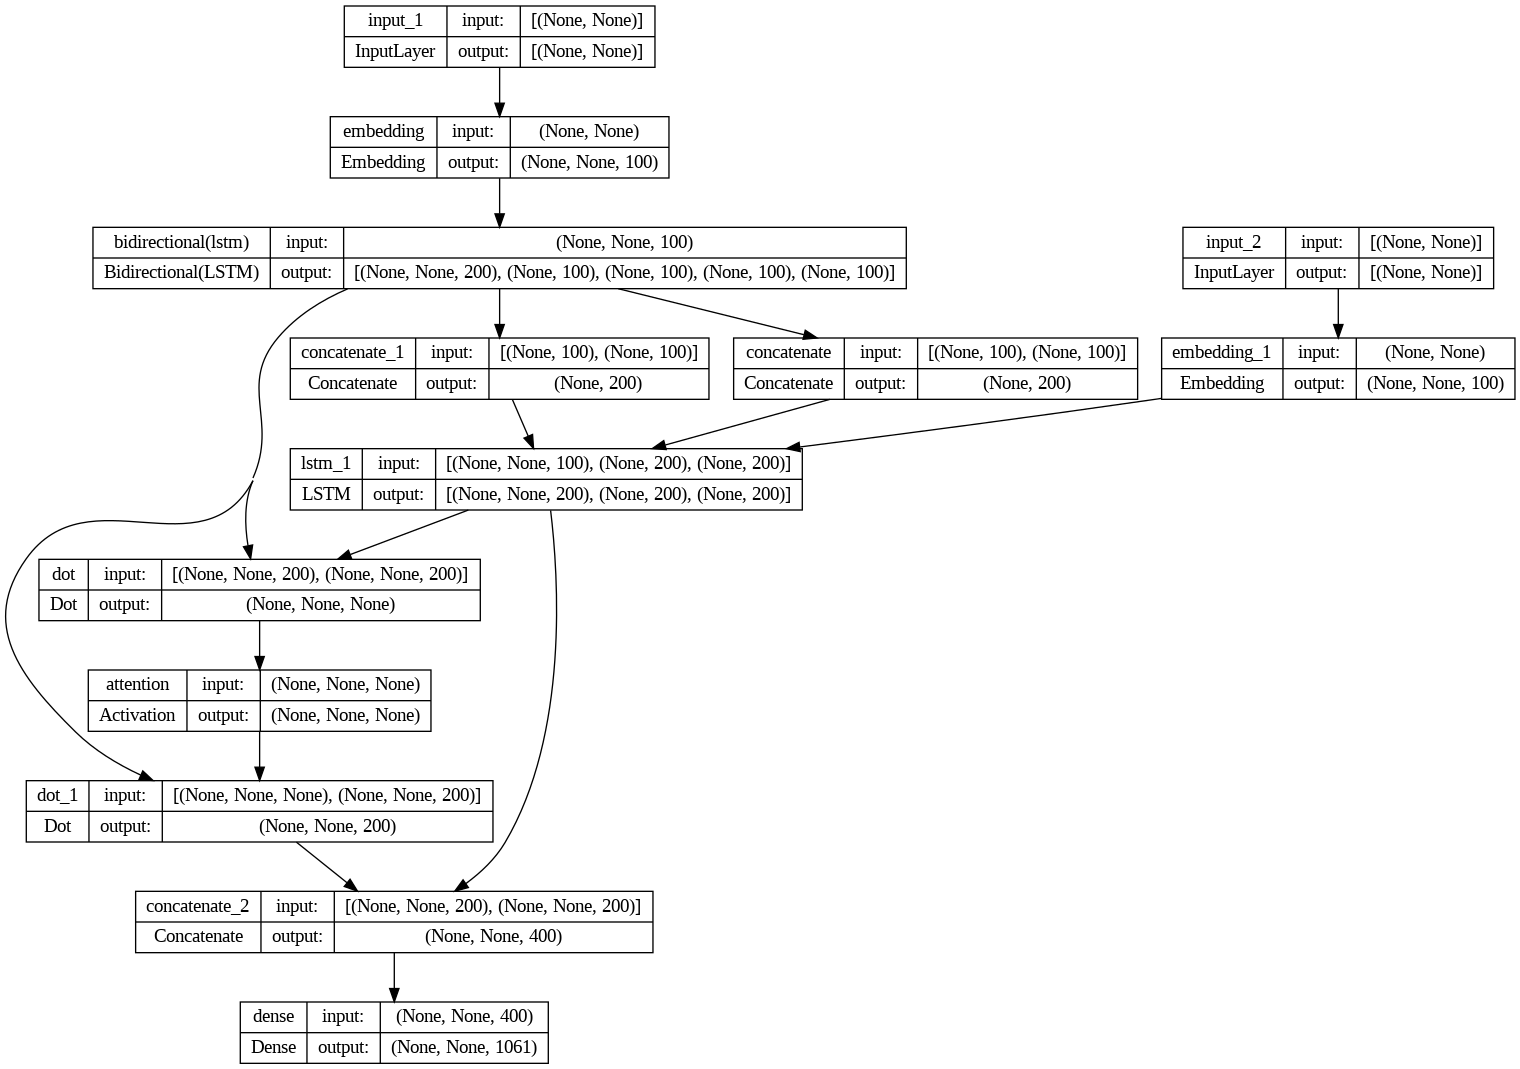

In [ ]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=8,
          epochs=100)

Epoch 1/100
13/13 [==============================] - 3s 259ms/step - loss: 6.9303 - acc: 0.0787
Epoch 2/100
13/13 [==============================] - 4s 311ms/step - loss: 6.3290 - acc: 0.0544
Epoch 3/100
13/13 [==============================] - 5s 404ms/step - loss: 6.0211 - acc: 0.0650
Epoch 4/100
13/13 [==============================] - 4s 304ms/step - loss: 5.9295 - acc: 0.0986
Epoch 5/100
13/13 [==============================] - 2s 165ms/step - loss: 5.8437 - acc: 0.0946
Epoch 6/100
13/13 [==============================] - 2s 160ms/step - loss: 5.7369 - acc: 0.0871
Epoch 7/100
13/13 [==============================] - 2s 145ms/step - loss: 5.6044 - acc: 0.1146
Epoch 8/100
13/13 [==============================] - 2s 116ms/step - loss: 5.4636 - acc: 0.1207
Epoch 9/100
13/13 [==============================] - 2s 158ms/step - loss: 5.3260 - acc: 0.1318
Epoch 10/100
13/13 [==============================] - 2s 173ms/step - loss: 5.2005 - acc: 0.1340
Epoch 11/100
13/13 [===================

In [ ]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    attention_density = []
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 150):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

In [ ]:
word_decoded_sents = []
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', data.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

1/1 [==============================] - 0s 20ms/step
-
Input sentence: 0    The effect of widespread dud targets two face ...
Name: input, dtype: object
Decoded sentence:  the effect of widespread dud targets two face up attack position monsters on the field _END
1/1 [==============================] - 0s 33ms/step
-
Input sentence: 1    tax on sales of stores for non residents are s...
Name: input, dtype: object
Decoded sentence:  capital gains tax on the sale of properties for nonresidents is set for in payable on profits earned on the difference of the property value between the
1/1 [==============================] - 0s 33ms/step
-
Input sentence: 2    Much many brands and sellers still in the market.
Name: input, dtype: object
Decoded sentence:  many brands and sellers still in the market _END
1/1 [==============================] - 0s 33ms/step
-
Input sentence: 3    this is is the latest Maintenance release of S...
Name: input, dtype: object
Decoded sentence:  this is is the latest 

In [ ]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [ ]:
target_sents = list(data.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]

In [ ]:
WER_word = calculate_WER(target_sents, word_decoded_sents)
print('Word level NMT WER = ', str(WER_word))

Word level NMT WER =  0.059942019099590724
